# Movie lens data engineering

This notebook presents more sophisticated feature engineering for the movie lens data. 

Due to the nature of the data set being rich in movie attributes (with no user attributes as well as context of interaction), most feature engineering therefore will be carried out on movies.

## Dataset download

In [1]:
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nvtabular.utils import download_file

MOVIE_LENS_DATA_PATH = './data/ml-25m/'

if not os.path.isdir(MOVIE_LENS_DATA_PATH):
    download_file(
        "http://files.grouplens.org/datasets/movielens/ml-25m.zip", os.path.join(MOVIE_LENS_DATA_PATH, "ml-25m.zip")
    )
!ls $MOVIE_LENS_DATA_PATH

NVTab_preprocessing  links.csv	 movies_features.csv	     tags.csv
README.txt	     ml-25m	 movies_features.parquet     test.csv
genome-scores.csv    ml-25m.zip  movies_preprocessed_v4.csv  train.csv
genome-tags.csv      movies.csv  ratings.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
links = pd.read_csv(MOVIE_LENS_DATA_PATH+"links.csv", dtype={'imdbId':str, 'tmdbId': str})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


In [6]:
numeric_features = []
cat_features = []

## Feature engineering for movies

### Movies rating statistics

We extract the average rating & numbers of ratings.

In [7]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [8]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [9]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [10]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [11]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [12]:
numeric_features += ['userId_count', 'rating_mean']

### Extract movie production year

In [13]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [14]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [15]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

### Movies genres
We use one hot encoding for the movie genre.

In [16]:
genre_split = movies['genres'].str.split('|', n=10, expand=True)
genre_split.head()

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None,None,None


In [17]:
genres = set()
for i in range(10):
    movies[i] = genre_split[i]
    genres = genres.union(set(genre_split[i].unique()))

In [18]:
genres.discard(None)
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [19]:
for genre in genres:
    movies[genre] = 0
    for i in range(10):
        movies[genre] = movies[genre] + (movies[i]==genre)

In [20]:
for i in range(10):
    movies.drop(i, axis=1, inplace=True)
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,IMAX,Musical,Horror,Sci-Fi,Film-Noir,Fantasy,Comedy,Drama,Crime,Documentary
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
len(genres)

20

In [22]:
#cat_features += ['genres']

### Content features

We use TF-IDF and SVD to turn text features (title, tag and genres) into numeric feature. 

In [23]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")

# create a mixed dataframe of movies title, genres and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,Sci-Fi,Film-Noir,Fantasy,Comedy,Drama,Crime,Documentary,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,1,0,0,0,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,1,0,0,0,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0,0,1,1,0,0,0,1361.0,Pixar,1.216146e+09


In [24]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [25]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))

In [26]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['genres', 'tag']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure Children Fantasy Robin Williams time...
2,3,Grumpier Old Men (1995),Comedy Romance funny best friend duringcredits...


#### TF-IDF vectorizer
Next step is to turn the text metadata into a matrix.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [28]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
len(tfidf.vocabulary_)

35768

In [30]:
!mkdir ./assets

mkdir: cannot create directory ‘./assets’: File exists


We save the TF-IDF object for subsequent transform of new movies.

In [31]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie
Note: for a new test movie, its TF-IDF representation can be computed as below:

In [32]:
new_movie_feat = tfidf.transform(['cartoon'])

In [33]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

#### SVD on TF-IDF matrix
The TF-IDF matrix is of numeric form, however, it is very high-dimensional and sparse. We use SVD to get an approximation of this matrix using only the most significant eigen vectors.

In [34]:
NUM_LATENT_FACTOR = 32

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


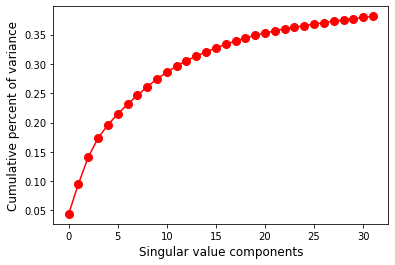

In [35]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [36]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [37]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,0.004380,0.041247,-0.019923,-0.010924,0.042256,0.030173,-0.001109,-0.024669,-0.005891,0.009079
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,0.003374,0.020182,-0.004953,-0.000222,0.016554,0.021829,-0.006461,-0.004684,0.006589,-0.012536
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,0.001277,0.022894,-0.011283,-0.007819,0.013768,0.008763,0.001761,-0.006100,0.007787,-0.011138
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008598,0.004705,...,-0.006559,-0.012607,0.003402,-0.003657,0.024146,-0.018959,-0.017758,0.014155,0.017245,-0.010751
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003467,...,-0.004688,0.062099,-0.028603,-0.014278,0.082398,-0.027782,-0.014957,-0.006554,0.008473,-0.022947


In [38]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9', 'SVD_latent_10', 'SVD_latent_11',
       'SVD_latent_12', 'SVD_latent_13', 'SVD_latent_14', 'SVD_latent_15',
       'SVD_latent_16', 'SVD_latent_17', 'SVD_latent_18', 'SVD_latent_19',
       'SVD_latent_20', 'SVD_latent_21', 'SVD_latent_22', 'SVD_latent_23',
       'SVD_latent_24', 'SVD_latent_25', 'SVD_latent_26', 'SVD_latent_27',
       'SVD_latent_28', 'SVD_latent_29', 'SVD_latent_30', 'SVD_latent_31'],
      dtype='object')

In [39]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [40]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,...,SVD_latent_23,SVD_latent_24,SVD_latent_25,SVD_latent_26,SVD_latent_27,SVD_latent_28,SVD_latent_29,SVD_latent_30,SVD_latent_31,movieId
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,0.041247,-0.019923,-0.010924,0.042256,0.030173,-0.001109,-0.024669,-0.005891,0.009079,1
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,0.020182,-0.004953,-0.000222,0.016554,0.021829,-0.006461,-0.004684,0.006589,-0.012536,2
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,0.022894,-0.011283,-0.007819,0.013768,0.008763,0.001761,-0.006100,0.007787,-0.011138,3
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008598,0.004705,...,-0.012607,0.003402,-0.003657,0.024146,-0.018959,-0.017758,0.014155,0.017245,-0.010751,4
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003467,...,0.062099,-0.028603,-0.014278,0.082398,-0.027782,-0.014957,-0.006554,0.008473,-0.022947,5


In [41]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [42]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,SVD_latent_22,SVD_latent_23,SVD_latent_24,SVD_latent_25,SVD_latent_26,SVD_latent_27,SVD_latent_28,SVD_latent_29,SVD_latent_30,SVD_latent_31
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,0.004380,0.041247,-0.019923,-0.010924,0.042256,0.030173,-0.001109,-0.024669,-0.005891,0.009079
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.003374,0.020182,-0.004953,-0.000222,0.016554,0.021829,-0.006461,-0.004684,0.006589,-0.012536
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0.001277,0.022894,-0.011283,-0.007819,0.013768,0.008763,0.001761,-0.006100,0.007787,-0.011138
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,-0.006559,-0.012607,0.003402,-0.003657,0.024146,-0.018959,-0.017758,0.014155,0.017245,-0.010751
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,-0.004688,0.062099,-0.028603,-0.014278,0.082398,-0.027782,-0.014957,-0.006554,0.008473,-0.022947


In [43]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

#### SVD transform new movie

Note: SVD transform of a new movie (with corresponding TF-IDF features) can be done as follows:

In [44]:
latent_matrix = svd.transform(new_movie_feat)

In [45]:
latent_matrix.shape

(1, 32)

We save the SVD object for subsequent transform of new movies.

In [46]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

###  Popularity score

We compute the [popularity score](https://www.kaggle.com/rounakbanik/movie-recommender-systems) for each movie within the set of all movies as well as within each genre as follows:

```Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)```

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole set


In [47]:
C = ratings['rating'].mean()
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [48]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on IMDB. We also see that the average rating for a movie on IMDB is 3.53 on a scale of 5. 2953 movies qualify to be on our chart.


In [49]:
qualified = movies[movies['userId_count'] >= m]

In [50]:
qualified.shape

(2953, 59)

In [51]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [52]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

<ipython-input-52-a4cac61d7166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [53]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [54]:
qualified.head(5)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,SVD_latent_23,SVD_latent_24,SVD_latent_25,SVD_latent_26,SVD_latent_27,SVD_latent_28,SVD_latent_29,SVD_latent_30,SVD_latent_31,wr
314,318,"Shawshank Redemption, The (1994)",Crime Drama,81482.0,4.413576,1994.0,1994.0,0,0,0,...,0.054184,-0.030151,-0.022620,0.041927,0.031803,0.008092,0.009801,0.005119,-0.057313,4.397639
840,858,"Godfather, The (1972)",Crime Drama,52498.0,4.324336,1972.0,1972.0,0,0,0,...,0.048721,0.012029,-0.000202,-0.003493,0.004454,0.006597,0.010762,-0.002098,-0.016601,4.302329
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,55366.0,4.284353,1995.0,1995.0,0,0,1,...,0.052566,-0.018535,-0.000092,0.025852,0.035893,-0.003805,0.011402,0.003112,-0.061259,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime Drama,34188.0,4.261759,1974.0,1974.0,0,0,0,...,0.080332,-0.009639,-0.013590,0.024291,0.012091,0.003861,-0.000620,0.003192,-0.027043,4.231098
522,527,Schindler's List (1993),Drama War,60411.0,4.247579,1993.0,1993.0,0,0,0,...,0.068858,0.065742,0.036286,-0.013887,0.013315,0.020826,0.023908,-0.060416,-0.043152,4.230248


In [55]:
cat_features += [g for g in genres]

#### Popularity score per genre

In [56]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [57]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')    

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
  5%|▌         | 1/20 [00:00<00:04,  4.27it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
 10%|█         | 2/20 [00:00<00:04,  4.09it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be 

In [58]:
movies.fillna(0, inplace=True)

In [59]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,Fantasy_wr,Fantasy_rank,Comedy_wr,Comedy_rank,Drama_wr,Drama_rank,Crime_wr,Crime_rank,Documentary_wr,Documentary_rank
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,3.884509,19.0,3.884509,58.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
movies.shape

(62423, 99)

In [61]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [62]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


In [63]:
print(len(cat_features))
print(len(numeric_features))

21
75


### Merging with IMDB ID

In [64]:
movies = movies.merge(links, on='movieId', how='left')

In [65]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Children,(no genres listed),Mystery,...,Comedy_wr,Comedy_rank,Drama_wr,Drama_rank,Crime_wr,Crime_rank,Documentary_wr,Documentary_rank,imdbId,tmdbId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,0,0,...,3.884509,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0114709,862
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113497,8844
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113228,15602
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0114885,31357
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113041,11862


In [66]:
movies.to_parquet(MOVIE_LENS_DATA_PATH+"movies_features.parquet", index=False)

In [67]:
movies.shape

(62423, 101)

# Divide into train and test

We use all examples for training, except the last-watched movies for testing.

In [68]:
ratings.tail()

,userId,movieId,rating,timestamp
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434
25000094,162541,63876,5.0,1240952515


## Forming binary dataset

To train a DLRM network, we will need binary labels. Herein we will employ a simple strategy. The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings >=4 and 0 are all ratings <=3.

In [69]:
ratings['label'] = 0
ratings.loc[ratings['rating']>3,'label'] = 1
ratings.loc[ratings['rating']<=3,'label'] = 0


In [70]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

In [71]:
# clean up data
del ratings['rating'], ratings['timestamp']

In [72]:
movies[cat_features] = movies[cat_features].astype('int32')
movies[numeric_features] = movies[numeric_features].astype('float32')

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [73]:
train_data = train_data.merge(movies, on='movieId')
train_data.head()

,userId,movieId,label,title,genres,userId_count,rating_mean,year,year_cat,Children,...,Comedy_wr,Comedy_rank,Drama_wr,Drama_rank,Crime_wr,Crime_rank,Documentary_wr,Documentary_rank,imdbId,tmdbId
0,124027,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
1,126033,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
2,42980,56587,0,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
3,68348,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
4,113495,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350


In [74]:
test_data = test_data.merge(movies, on='movieId')
test_data.head()

,userId,movieId,label,title,genres,userId_count,rating_mean,year,year_cat,Children,...,Comedy_wr,Comedy_rank,Drama_wr,Drama_rank,Crime_wr,Crime_rank,Documentary_wr,Documentary_rank,imdbId,tmdbId
0,99476,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,0,...,0.0,0.0,3.865884,170.0,0.0,0.0,0.0,0.0,2194499,122906
1,97150,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,0,...,0.0,0.0,3.865884,170.0,0.0,0.0,0.0,0.0,2194499,122906
2,56108,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,0,...,0.0,0.0,3.865884,170.0,0.0,0.0,0.0,0.0,2194499,122906
3,109615,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,0,...,0.0,0.0,3.865884,170.0,0.0,0.0,0.0,0.0,2194499,122906
4,110819,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,0,...,0.0,0.0,3.865884,170.0,0.0,0.0,0.0,0.0,2194499,122906


In [75]:
cat_features = ['userId', 'movieId']
numeric_features = [] #['rating_mean']

In [76]:
BASE_DIR = MOVIE_LENS_DATA_PATH + 'NVTab_preprocessing/'
!mkdir $BASE_DIR

train_data[cat_features+numeric_features+['label']].to_parquet(BASE_DIR + "train.parquet", row_group_size=1000000, engine="pyarrow")
test_data[cat_features+numeric_features+['label']].to_parquet(BASE_DIR + "test.parquet", row_group_size=1000000, engine="pyarrow")

mkdir: cannot create directory ‘./data/ml-25m/NVTab_preprocessing/’: File exists


In [77]:
!ls -l $BASE_DIR

total 192676
drwxr-xr-x 2 nobody nogroup      4096 May  5 01:00 test
-rw-r--r-- 1 nobody nogroup  39407423 May  5 01:22 test.parquet
drwxr-xr-x 5 nobody nogroup      4096 May  5 01:00 test_dask
drwxr-xr-x 2 nobody nogroup      4096 May  5 01:00 train
-rw-r--r-- 1 nobody nogroup 157095225 May  5 01:22 train.parquet


## Preprocessing with NVTabular

In [78]:
# External dependencies
import os
import gc
import pathlib
from os import path
import glob
import shutil

import numpy as np
import cudf

# NVTabular
import nvtabular as nvt
from nvtabular.io import Shuffle
from nvtabular.utils import device_mem_size

In [79]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import rmm

In [80]:
# define some information about where to get our data
dask_workdir = pathlib.Path(BASE_DIR, "test_dask", "workdir")

# Make sure we have a clean worker space for Dask
if pathlib.Path.is_dir(dask_workdir):
    shutil.rmtree(dask_workdir)
dask_workdir.mkdir(parents=True)

# Get device memory capacity
capacity = device_mem_size(kind="total")

In [81]:
# Deploy a Single-Machine Multi-GPU Cluster
protocol = "tcp"  # "tcp" or "ucx"
visible_devices = "0,1,2,3,4,5,6,7"  # Select devices to place workers
device_spill_frac = 0.5  # Spill GPU-Worker memory to host at this limit.
# Reduce if spilling fails to prevent
# device memory errors.
cluster = None  # (Optional) Specify existing scheduler port
if cluster is None:
    cluster = LocalCUDACluster(
        protocol=protocol,
        CUDA_VISIBLE_DEVICES=visible_devices,
        local_directory=dask_workdir,
        device_memory_limit=capacity * device_spill_frac,
    )

# Create the distributed client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38294 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 540.96 GB


In [82]:
# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=None,  # Use default size
    )


client.run(_rmm_pool)

{'tcp://127.0.0.1:32931': None,
 'tcp://127.0.0.1:36399': None,
 'tcp://127.0.0.1:38640': None,
 'tcp://127.0.0.1:39467': None,
 'tcp://127.0.0.1:40073': None,
 'tcp://127.0.0.1:40827': None,
 'tcp://127.0.0.1:41115': None,
 'tcp://127.0.0.1:46042': None}

In [83]:
CATEGORICAL_COLUMNS = cat_features 
NUMERICAL_COLUMNS = []; #numeric_features
LABEL_COLUMNS = ["label"]

print(len(CATEGORICAL_COLUMNS), len(NUMERICAL_COLUMNS))

2 0


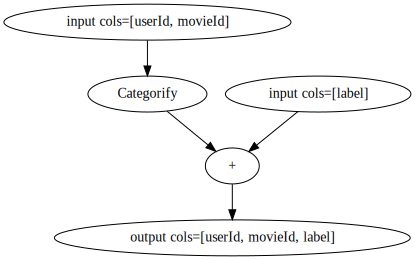

In [84]:
output = (CATEGORICAL_COLUMNS >> nvt.ops.Categorify(cat_cache="device")) + \
         LABEL_COLUMNS
#(NUMERICAL_COLUMNS >> nvt.ops.Normalize()) + \
         
(output).graph

In [85]:
workflow = nvt.Workflow(output)

In [86]:
!ls -l $BASE_DIR

total 192676
drwxr-xr-x 2 nobody nogroup      4096 May  5 01:00 test
-rw-r--r-- 1 nobody nogroup  39407423 May  5 01:22 test.parquet
drwxr-xr-x 5 nobody nogroup      4096 May  5 01:22 test_dask
drwxr-xr-x 2 nobody nogroup      4096 May  5 01:00 train
-rw-r--r-- 1 nobody nogroup 157095225 May  5 01:22 train.parquet


In [87]:
train_dataset = nvt.Dataset(BASE_DIR + "train.parquet", part_size="100MB")
test_dataset = nvt.Dataset(BASE_DIR + "test.parquet", part_size="100MB")

In [88]:
%%time

workflow.fit(train_dataset)

CPU times: user 2.59 s, sys: 560 ms, total: 3.15 s
Wall time: 9.1 s


In [89]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

#for col in NUMERICAL_COLUMNS:
#    dict_dtypes[col] = np.float32
    
for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [90]:
train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")
!rm -rf $train_dir && rm -rf $test_dir

In [91]:
workflow.transform(train_dataset).to_parquet(
    output_path=BASE_DIR + "train/",
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    conts=NUMERICAL_COLUMNS,
    dtypes=dict_dtypes,
)


In [92]:
workflow.transform(test_dataset).to_parquet(
    output_path=BASE_DIR + "test/",
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    conts=NUMERICAL_COLUMNS,
    dtypes=dict_dtypes,
)

In [93]:
import dask 
print(dask.compute(test_dataset.to_ddf().shape))
test_dataset.to_ddf().head()

((5000019, 3),)


,userId,movieId,label
0,99476,104374,1
1,97150,104374,1
2,56108,104374,1
3,109615,104374,1
4,110819,104374,1


In [94]:
print(dask.compute(train_dataset.to_ddf().shape))

((20000076, 3),)


# Training with HugeCTR

In [95]:
from nvtabular.ops import get_embedding_sizes

embeddings = get_embedding_sizes(workflow)
print(embeddings)

{'movieId': (56586, 512), 'userId': (162542, 512)}


In [96]:
slot_size_array = [embeddings[cat][0] for cat in embeddings.keys()]
slot_size_array

[56586, 162542]

In [97]:
total_cardinality = 0
for cat in embeddings.keys():
    total_cardinality += embeddings[cat][0]
total_cardinality

219128

In [98]:
BASE_DIR

'./data/ml-25m/NVTab_preprocessing/'

import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0,1,2,3,4,5,6,7]],
    max_iter=100001,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=10000,
    snapshot=10000,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False, learning_rate=1e-4
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=len(numeric_features),
        dense_name="dense",
        slot_size_array=slot_size_array,
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, len(numeric_features), 1, len(numeric_features))
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.LocalizedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=500000,
        embedding_vec_size=16,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["dense"],
        top_names=["fc1"],
        num_output=32,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc1"], top_names=["relu1"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=64,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc2"], top_names=["relu2"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=16,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc3"], top_names=["relu3"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Interaction,
        bottom_names=["relu3", "sparse_embedding1"],
        top_names=["interaction1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["interaction1"],
        top_names=["fc4"],
        num_output=64,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc4"], top_names=["relu4"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu4"],
        top_names=["fc5"],
        num_output=64,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc5"], top_names=["relu5"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu5"],
        top_names=["fc6"],
        num_output=64,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc6"], top_names=["relu6"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu6"],
        top_names=["fc7"],
        num_output=64,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc7"], top_names=["relu7"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu7"],
        top_names=["fc8"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc8", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()

import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0,1,2,3,4,5,6,7]],
    max_iter=10000,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=3200,
    snapshot=3200,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=75,
        dense_name="dense",
        slot_size_array=[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 58987,
 162542,
 137],
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, 75, 1, 75)
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.LocalizedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=221726+1,
        embedding_vec_size=128,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["dense"],
        top_names=["fc1"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc1"], top_names=["relu1"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc2"], top_names=["relu2"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc3"], top_names=["relu3"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Interaction,
        bottom_names=["relu3", "sparse_embedding1"],
        top_names=["interaction1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["interaction1"],
        top_names=["fc4"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc4"], top_names=["relu4"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu4"],
        top_names=["fc5"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc5"], top_names=["relu5"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu5"],
        top_names=["fc6"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc6"], top_names=["relu6"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu6"],
        top_names=["fc7"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc7"], top_names=["relu7"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu7"],
        top_names=["fc8"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc8", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()

## Using user and item only

In [ ]:
import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0,1,2,3,4,5,6,7]],
    max_iter=100001,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=10000,
    snapshot=10000,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False, learning_rate=1e-4
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=0,
        dense_name="dense",
        slot_size_array=slot_size_array,
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, len(cat_features), 1, len(cat_features))
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.DistributedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=500000,
        embedding_vec_size=16,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Reshape,
        bottom_names=["sparse_embedding1"],
        top_names=["reshape1"],
        leading_dim=32,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["reshape1"],
        top_names=["fc1"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.ReLU,
        bottom_names=["fc1"],
        top_names=["relu1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.ReLU,
        bottom_names=["fc2"],
        top_names=["relu2"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc3", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()

In [ ]:
import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0,1,2,3,4,5,6,7]],
    max_iter=100001,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=10000,
    snapshot=10000,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False, learning_rate=1e-4
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=0,
        dense_name="dense",
        slot_size_array=[56586, 162542],
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, 2, 1, 2)
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.DistributedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=500000,
        embedding_vec_size=16,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Reshape,
        bottom_names=["sparse_embedding1"],
        top_names=["reshape1"],
        leading_dim=32,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["reshape1"],
        top_names=["fc1"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.ReLU,
        bottom_names=["fc1"],
        top_names=["relu1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.ReLU,
        bottom_names=["fc2"],
        top_names=["relu2"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc3", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()